In [2]:
import concurrent
from datetime import datetime, timedelta
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
# from keras.src.layers import LSTM, Dense
# from keras import Sequential
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [142]:
import functions
# Do stuff...

# (Later after editing functions.py)
import importlib
importlib.reload(functions)
from functions import plot_data_distributions, prepare_data,train_test_cv_models

## Loading and parsing


In [141]:
# Importing the dataset
dataset = pd.read_csv('./trainingset.txt',na_values="unknown", sep=",", decimal=".")

In [88]:
dataset

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,44,JobCat9,single,secondary,no,29,yes,no,NaN,5,may,0,1,-1,0,NaN,TypeA
1,47,JobCat3,married,NaN,no,1506,yes,no,NaN,5,may,0,1,-1,0,NaN,TypeA
2,31,NaN,single,NaN,no,1,no,no,NaN,5,may,0,1,-1,0,NaN,TypeA
3,26,JobCat6,single,tertiary,no,447,yes,yes,NaN,5,may,0,1,-1,0,NaN,TypeA
4,42,JobCat4,divorced,tertiary,yes,2,yes,no,NaN,5,may,0,1,-1,0,NaN,TypeA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27267,73,JobCat2,married,secondary,no,2850,no,no,cellular,17,nov,0,1,40,8,failure,TypeB
27268,23,JobCat9,single,secondary,no,505,no,yes,cellular,17,nov,0,2,-1,0,NaN,TypeB
27269,72,JobCat2,married,secondary,no,5715,no,no,cellular,17,nov,0,5,184,3,success,TypeB
27270,57,JobCat3,married,secondary,no,668,no,no,telephone,17,nov,0,4,-1,0,NaN,TypeA


<Axes: >

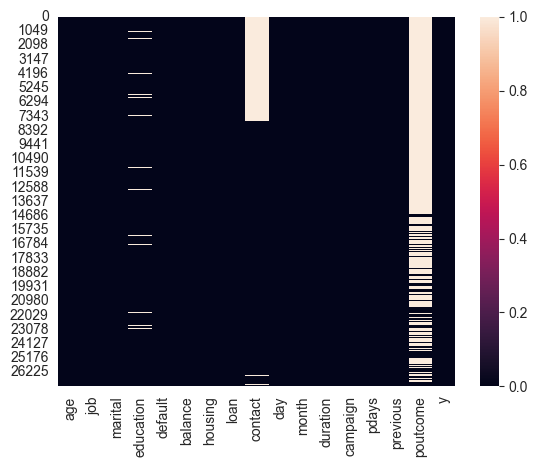

In [89]:
sns.heatmap(dataset.isnull())


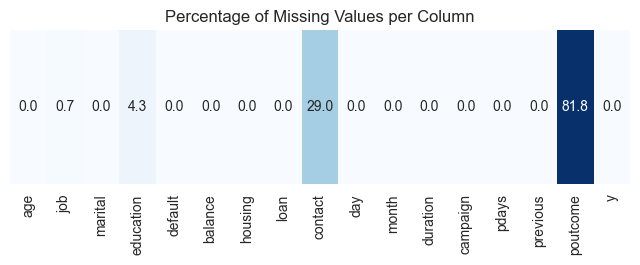

In [90]:
missing_percent = (dataset.isnull().sum() / len(dataset)) * 100


missing_df = pd.DataFrame(missing_percent).T  

plt.figure(figsize=(8, 2))
sns.heatmap(missing_df, annot=True, fmt=".1f", cmap="Blues", cbar=False)
plt.title('Percentage of Missing Values per Column')
plt.yticks([]) 
plt.show()


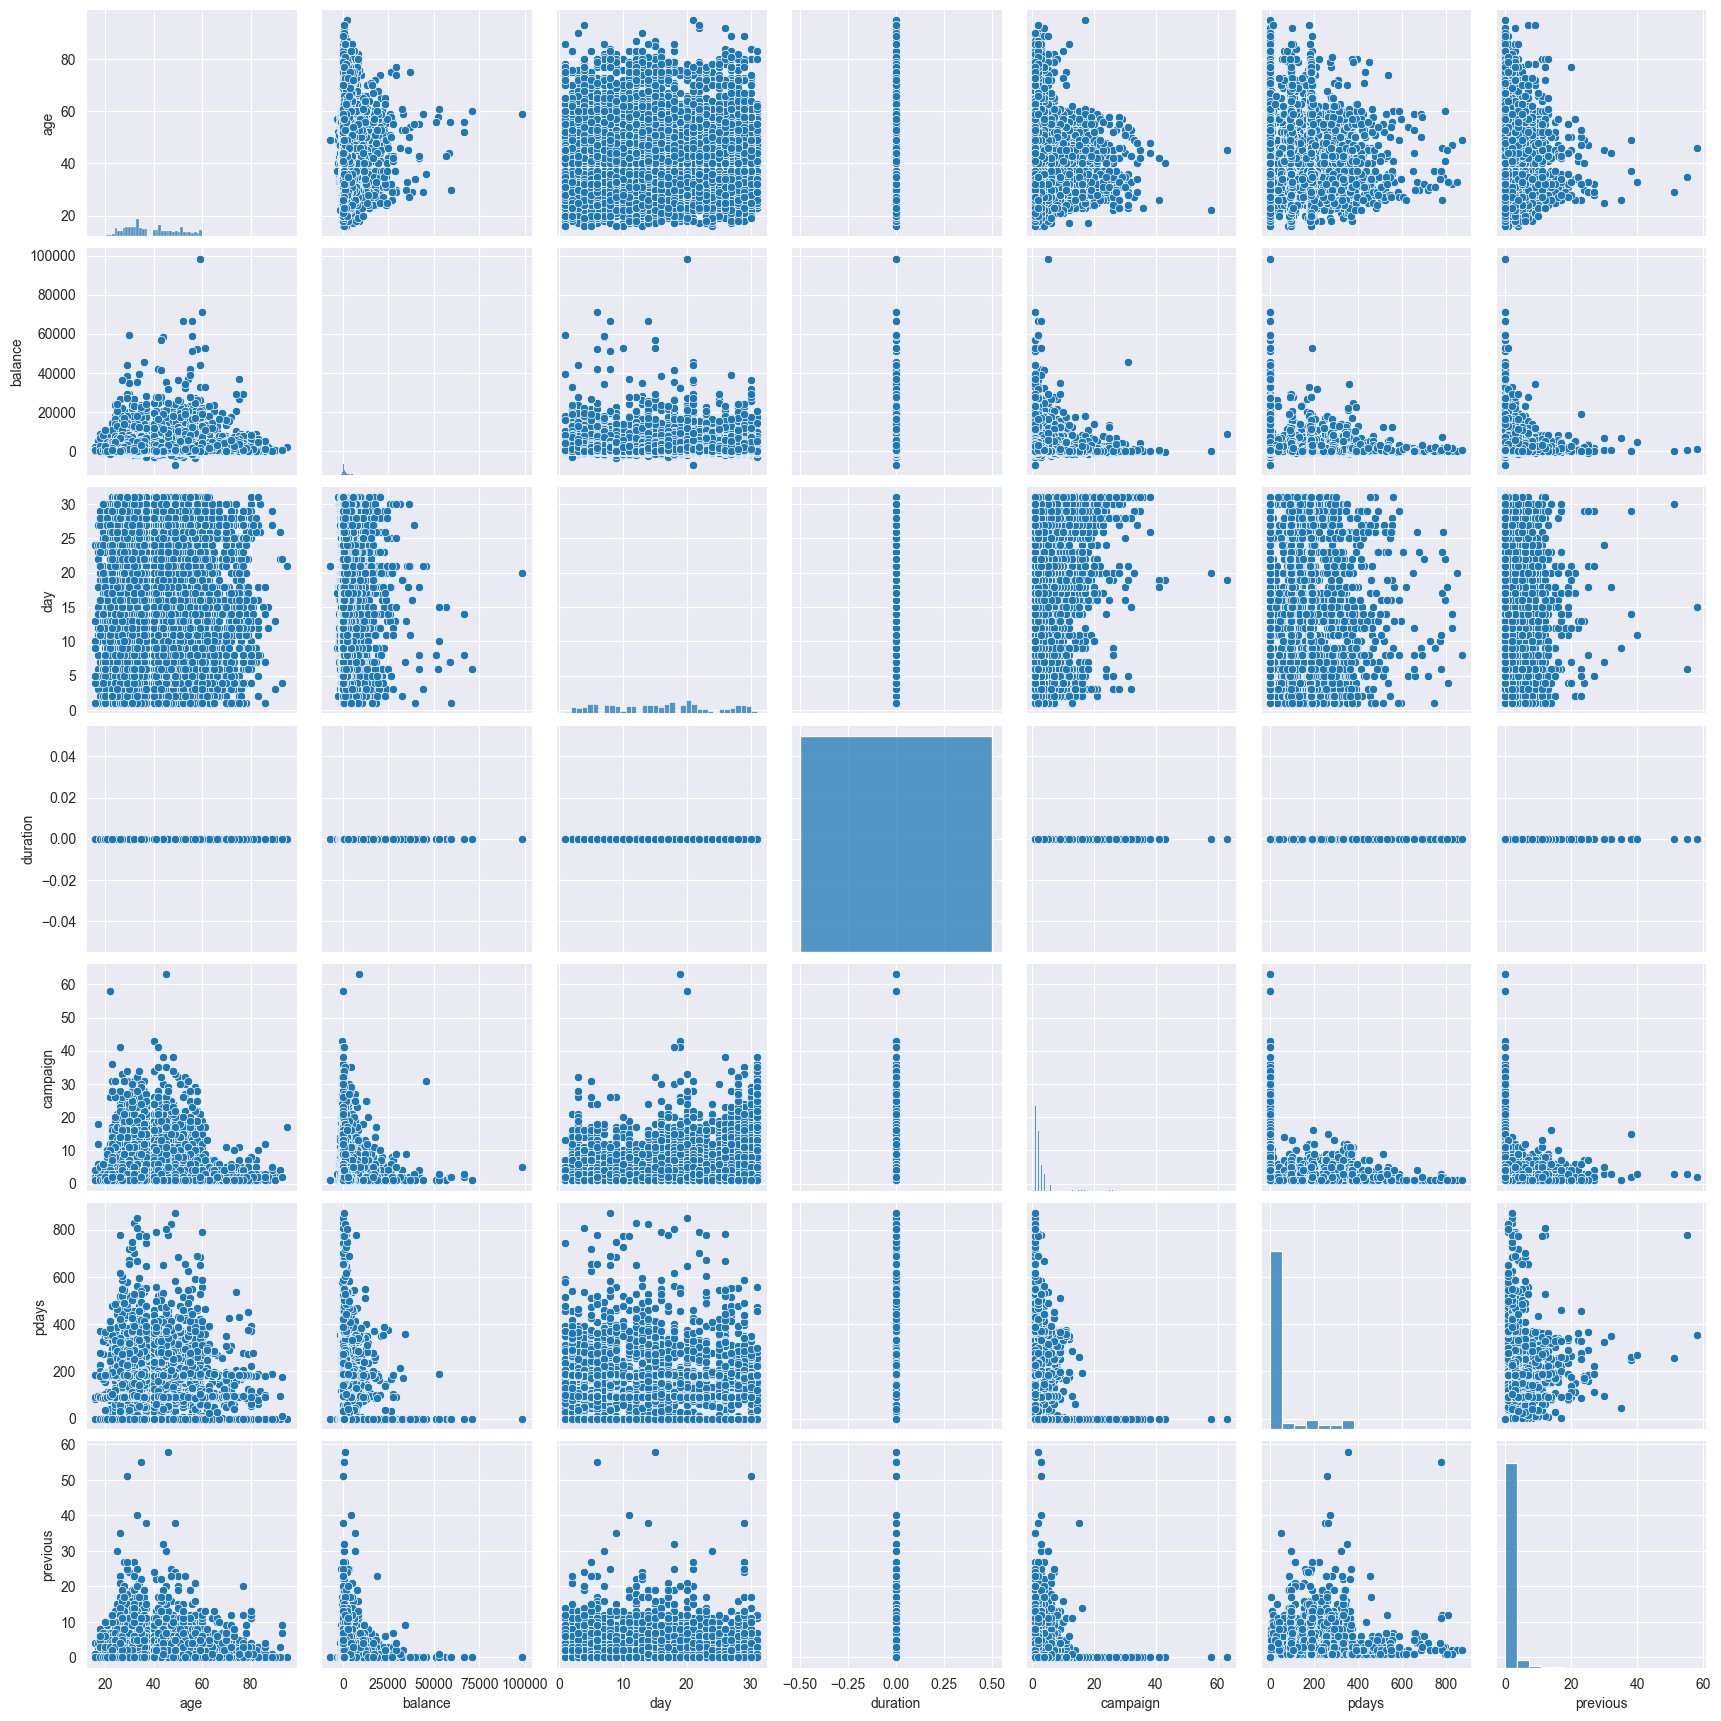

In [94]:
sns.pairplot(dataset)


In [91]:
dataset[['duration']].value_counts()

duration
0           27272
Name: count, dtype: int64

duration -> all are 0 -> drop  \
poutcome -> 80% missing values -> drop \
contact -> 29% missing values -> use mode to fill \
job -> 0.7% missing values -> drop rows, assumption is that job is imporant, better to drop a few rows \ 
education -> 4.3% missing values ->  find a way to inpute those values \


In [97]:

job_education_ct = pd.crosstab(dataset['job'], dataset['education'], normalize='index') * 100
print(job_education_ct.round(1))


education  primary  secondary  tertiary
job                                    
JobCat1      54.90      31.40     13.80
JobCat10     20.70      56.90     22.50
JobCat11      4.00      84.50     11.50
JobCat2      37.30      45.70     17.10
JobCat3      40.60      57.90      1.50
JobCat4      13.30      38.00     48.70
JobCat5       5.30      65.30     29.30
JobCat6       3.40      12.10     84.60
JobCat7       8.90      86.70      4.40
JobCat8       8.60      39.40     52.00
JobCat9       2.30      70.60     27.10


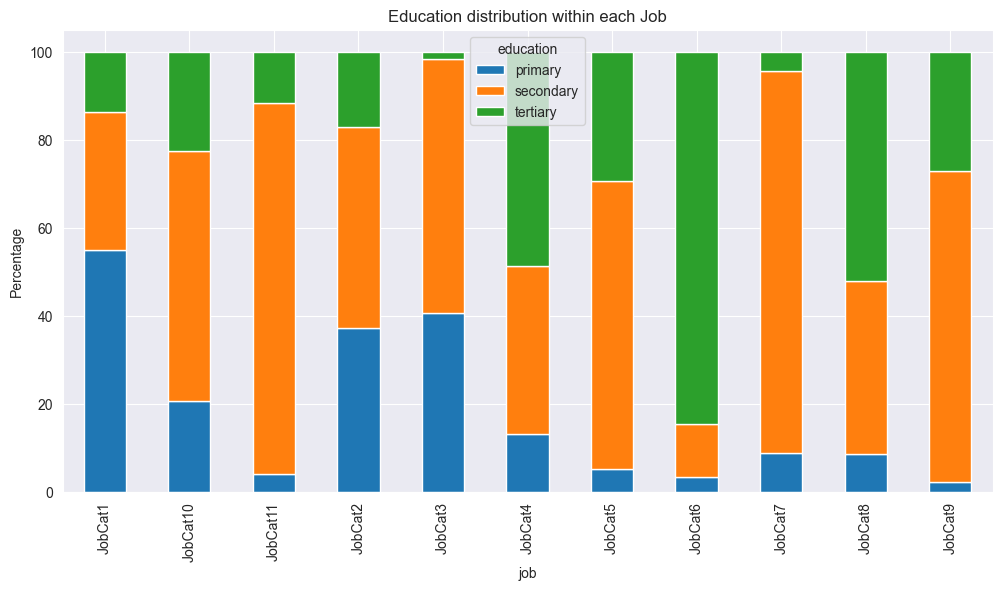

In [98]:
job_education_ct.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Education distribution within each Job')
plt.ylabel('Percentage')
plt.show()


## General statistics

In [100]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27094 entries, 0 to 27271
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        27094 non-null  int64 
 1   job        27094 non-null  object
 2   marital    27094 non-null  object
 3   education  27094 non-null  object
 4   default    27094 non-null  object
 5   balance    27094 non-null  int64 
 6   housing    27094 non-null  object
 7   loan       27094 non-null  object
 8   contact    27094 non-null  object
 9   day        27094 non-null  int64 
 10  month      27094 non-null  object
 11  campaign   27094 non-null  int64 
 12  pdays      27094 non-null  int64 
 13  previous   27094 non-null  int64 
 14  y          27094 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.3+ MB


## DataFrame Statistics Collection

- Initializes `stats_dict` to store various statistical measures.
- Iterates through DataFrame columns, computing statistics for each.
- Numeric checks for mean, min, max, etc., and non-numeric handling for mode.
- Results are compiled into `stats_df`, a DataFrame indexed by column names.


In [69]:

# Initialize an empty dictionary to store the results
stats_dict = {
    "Mean": [],
    "Min": [],
    "Max": [],
    "Mode": [],
    "Standard Deviation": [],
    "Percentage of Missing Values": [],
    "Median": [],
    "Range": [],
    "Interquartile Range (IQR)": [],
    "Variance": [],
    "25th Percentile": [],
    "75th Percentile": [],
    "Skewness": [],
    "Kurtosis": [],
}

# Loop through each column in the DataFrame
for column in dataset.columns:
    column_data = dataset[column]
    # Check if the column is numeric for certain calculations
    is_numeric = pd.api.types.is_numeric_dtype(column_data)

    # Calculate each statistic
    stats_dict["Mean"].append(column_data.mean() if is_numeric else np.nan)
    stats_dict["Min"].append(column_data.min() if is_numeric else np.nan)
    stats_dict["Max"].append(column_data.max() if is_numeric else np.nan)

    # Handling mode calculation
    mode_series = column_data.mode()
    stats_dict["Mode"].append(mode_series.iloc[0] if not mode_series.empty else np.nan)

    stats_dict["Standard Deviation"].append(column_data.std() if is_numeric else np.nan)
    stats_dict["Percentage of Missing Values"].append(column_data.isna().mean() * 100)
    stats_dict["Median"].append(column_data.median() if is_numeric else np.nan)
    stats_dict["Range"].append(column_data.max() - column_data.min() if is_numeric else np.nan)
    stats_dict["Interquartile Range (IQR)"].append(column_data.quantile(0.75) - column_data.quantile(0.25) if is_numeric else np.nan)
    stats_dict["Variance"].append(column_data.var() if is_numeric else np.nan)
    stats_dict["25th Percentile"].append(column_data.quantile(0.25) if is_numeric else np.nan)
    stats_dict["75th Percentile"].append(column_data.quantile(0.75) if is_numeric else np.nan)
    stats_dict["Skewness"].append(column_data.skew() if is_numeric else np.nan)
    stats_dict["Kurtosis"].append(column_data.kurtosis() if is_numeric else np.nan)

# Convert the dictionary to a DataFrame
stats_df = pd.DataFrame(stats_dict, index=dataset.columns)


## Styling DataFrame for Visualization

- Applies a background gradient (`coolwarm` color map) to `stats_df` along rows.
- Formats all numeric values to two decimal places.
- Stores the styled DataFrame in `styled_df`.


In [70]:
styled_df = stats_df.style.background_gradient(cmap='coolwarm',axis=0)
styled_df = styled_df.format(na_rep='-', precision=2)
styled_df

,Mean,Min,Max,Mode,Standard Deviation,Percentage of Missing Values,Median,Range,Interquartile Range (IQR),Variance,25th Percentile,75th Percentile,Skewness,Kurtosis
age,39.84,16.00,95.00,30,11.41,0.00,37.00,79.00,17.00,130.19,31.00,48.00,0.60,-0.06
job,-,-,-,JobCat3,-,0.00,-,-,-,-,-,-,-,-
marital,-,-,-,married,-,0.00,-,-,-,-,-,-,-,-
education,-,-,-,secondary,-,0.00,-,-,-,-,-,-,-,-
default,-,-,-,no,-,0.00,-,-,-,-,-,-,-,-
balance,1358.39,-6847.00,98417.00,0,3013.65,0.00,447.00,105264.00,1342.00,9082058.63,73.00,1415.00,8.06,127.03
housing,-,-,-,yes,-,0.00,-,-,-,-,-,-,-,-
loan,-,-,-,no,-,0.00,-,-,-,-,-,-,-,-
contact,-,-,-,cellular,-,0.00,-,-,-,-,-,-,-,-
day,15.78,1.00,31.00,20,8.30,0.00,16.00,30.00,13.00,68.87,8.00,21.00,0.09,-1.05


## Outlier Detection

#### Statistical methods

## Outlier Detection in DataFrame

- Initializes `outlier_counts` to store outlier count per column.
- Iterates through numeric columns of `dataset`.
- Retrieves mean, standard deviation, and IQR from `stats_df`.
- Calculates outliers based on standard deviation and IQR criteria.
- Aggregates outlier counts in `outlier_counts` dictionary.
- Converts `outlier_counts` to DataFrame `outliers_df` for display.


In [79]:
# Initialize a dictionary to store the outlier counts and percentages
outlier_stats = {}

# Total number of entries (rows)
n_rows = len(dataset)

# Loop through each numeric column
for column in dataset.select_dtypes(include=[np.number]).columns:
    # Fetch stats
    mean = stats_df.at[column, 'Mean']
    std_dev = stats_df.at[column, 'Standard Deviation']
    iqr_25 = stats_df.at[column, '25th Percentile']
    iqr_75 = stats_df.at[column, '75th Percentile']

    # Count outliers
    count_below_3_std_dev = (dataset[column] < (mean - 3 * std_dev)).sum()
    count_above_3_std_dev = (dataset[column] > (mean + 3 * std_dev)).sum()
    count_below_25_iqr = (dataset[column] < (iqr_25 - 1.5 * (iqr_75 - iqr_25))).sum()
    count_above_75_iqr = (dataset[column] > (iqr_75 + 1.5 * (iqr_75 - iqr_25))).sum()

    # Calculate percentages
    pct_below_3_std_dev = (count_below_3_std_dev / n_rows) * 100
    pct_above_3_std_dev = (count_above_3_std_dev / n_rows) * 100
    pct_below_25_iqr = (count_below_25_iqr / n_rows) * 100
    pct_above_75_iqr = (count_above_75_iqr / n_rows) * 100

    # Store both counts and percentages
    outlier_stats[column] = [
        count_below_3_std_dev, pct_below_3_std_dev,
        count_above_3_std_dev, pct_above_3_std_dev,
        count_below_25_iqr, pct_below_25_iqr,
        count_above_75_iqr, pct_above_75_iqr
    ]

# Create a DataFrame
outliers_df = pd.DataFrame.from_dict(
    outlier_stats, 
    orient='index',
    columns=[
        'Count Below 3 Std Dev', 'Percent Below 3 Std Dev',
        'Count Above 3 Std Dev', 'Percent Above 3 Std Dev',
        'Count Below 25th IQR', 'Percent Below 25th IQR',
        'Count Above 75th IQR', 'Percent Above 75th IQR'
    ]
)

# Display nicely
pd.options.display.float_format = '{:.2f}'.format
display(outliers_df)


,Count Below 3 Std Dev,Percent Below 3 Std Dev,Count Above 3 Std Dev,Percent Above 3 Std Dev,Count Below 25th IQR,Percent Below 25th IQR,Count Above 75th IQR,Percent Above 75th IQR
age,0,0.00,180,0.66,0,0.00,200,0.74
balance,0,0.00,442,1.63,14,0.05,2861,10.56
day,0,0.00,0,0.00,0,0.00,0,0.00
campaign,0,0.00,569,2.10,0,0.00,1778,6.56
pdays,0,0.00,1031,3.81,0,0.00,4938,18.23
previous,0,0.00,498,1.84,0,0.00,4938,18.23


## Outlier Detection in DataFrame
Percent Above 3 Std Dev :
0.66
1.63
0.00
2.10
3.81
1.84

Values above 3 standard deviations are considered outliers. \
The percentage of outliers in each column is relatively low, \
indicating that the data is not heavily skewed by extreme values. \
We can proceed with further analysis without significant concerns about outliers.

#### Visual methods

## Outlier Visualization for Numeric Columns

- Sets up a subplot for each numeric column in `dataset`.
- Iterates through numeric columns, plotting each as a scatter plot.
- Adds horizontal lines to indicate:
  - Mean (red solid line).
  - ±3 standard deviations (green dashed lines).
  - 25th and 75th IQR boundaries (blue dotted lines).
- Each plot is titled and labeled for clarity.
- Displays the plots in a grid layout.


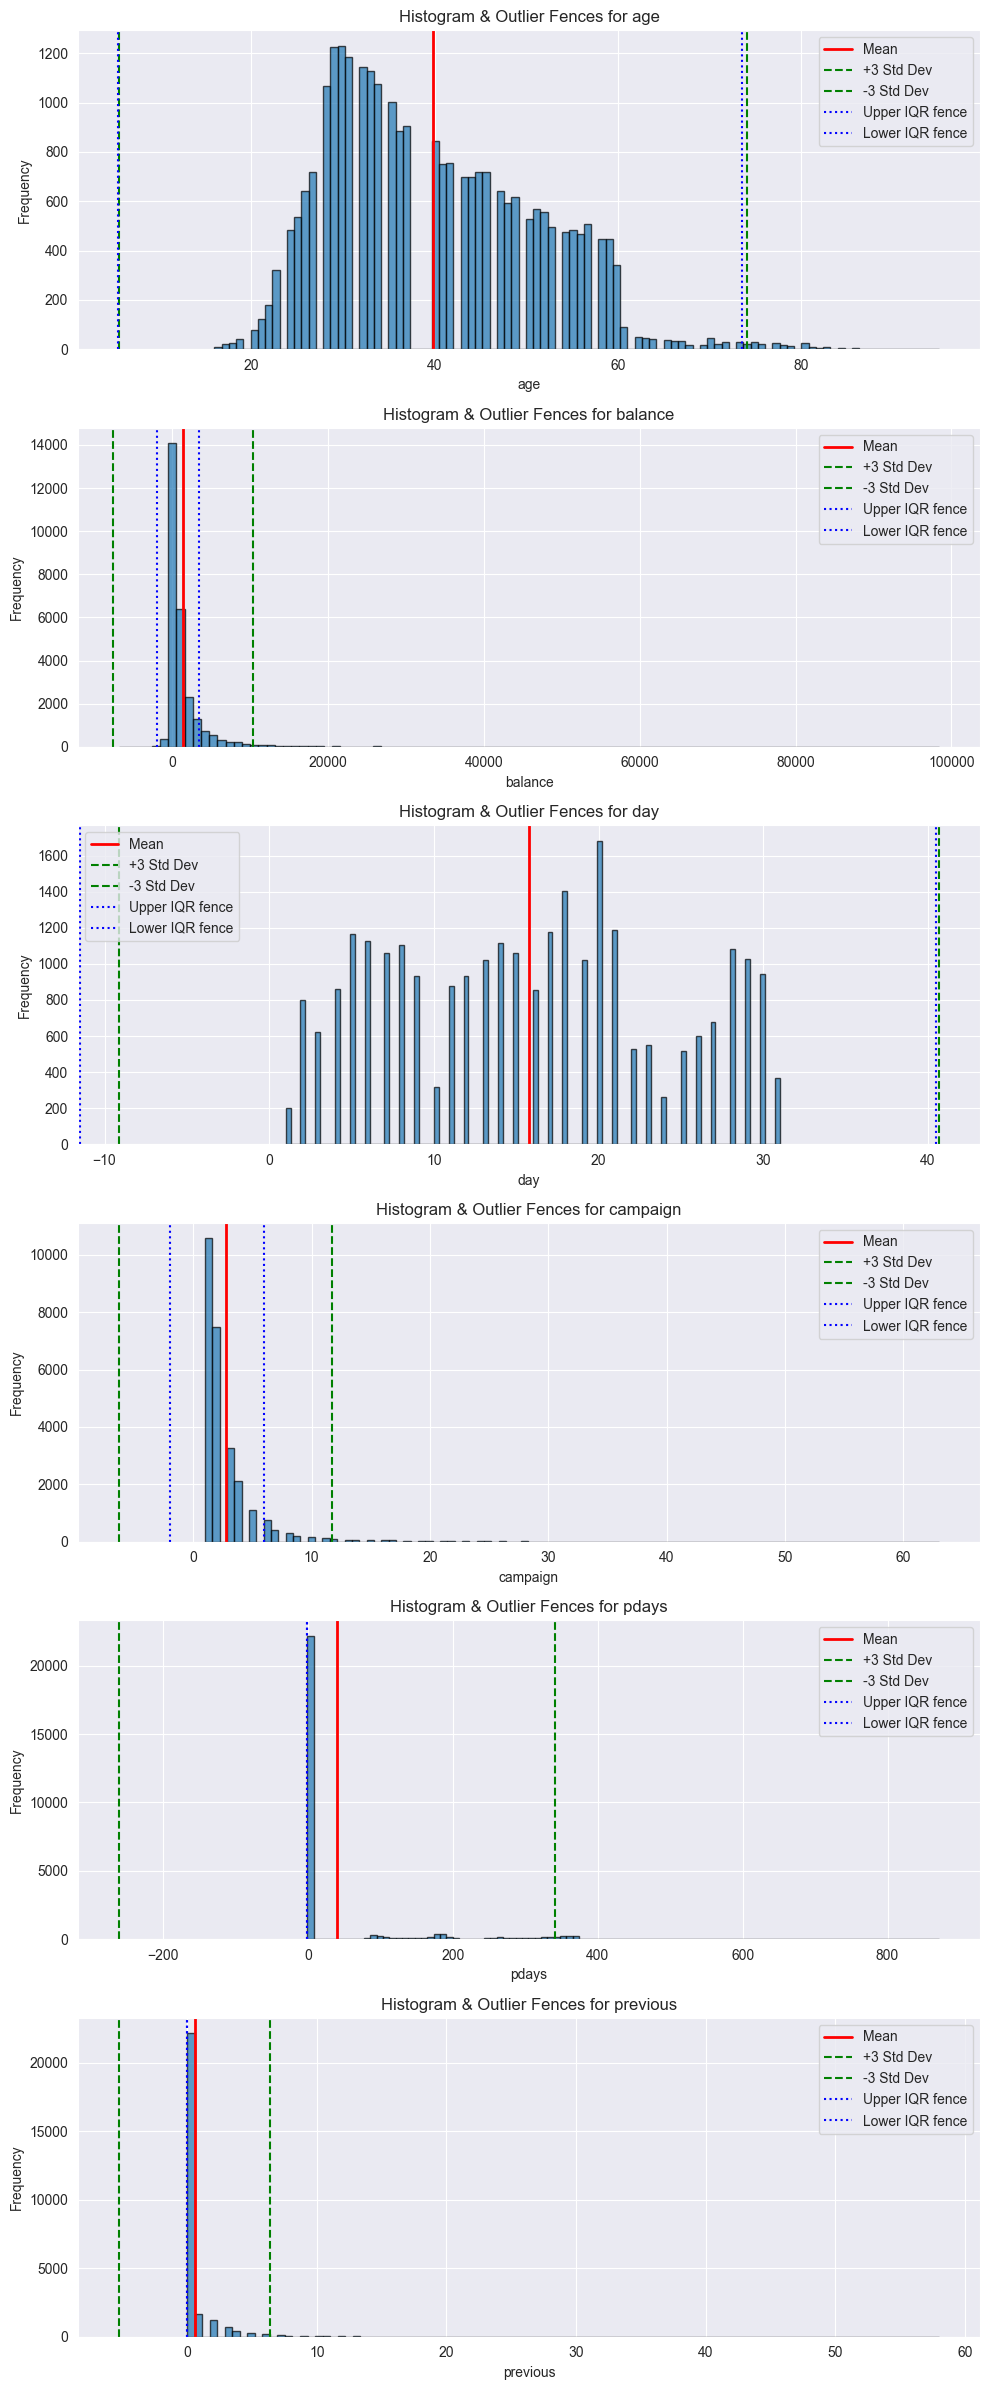

In [72]:
num_cols = dataset.select_dtypes(include=[np.number]).columns
n = len(num_cols)

fig, axs = plt.subplots(nrows=n, figsize=(10, 4 * n))

for idx, col in enumerate(num_cols):
    mean = stats_df.at[col, 'Mean']
    std = stats_df.at[col, 'Standard Deviation']
    q25 = stats_df.at[col, '25th Percentile']
    q75 = stats_df.at[col, '75th Percentile']
    iqr = q75 - q25

    # histogram
    axs[idx].hist(dataset[col].dropna(), bins=100, edgecolor='black', alpha=0.7)
    
    # summary stat lines
    axs[idx].axvline(mean, color='r', linestyle='-', linewidth=2, label='Mean')
    axs[idx].axvline(mean + 3*std, color='g', linestyle='--', label='+3 Std Dev')
    axs[idx].axvline(mean - 3*std, color='g', linestyle='--', label='-3 Std Dev')
    axs[idx].axvline(q75 + 1.5*iqr, color='b', linestyle=':', label='Upper IQR fence')
    axs[idx].axvline(q25 - 1.5*iqr, color='b', linestyle=':', label='Lower IQR fence')

    axs[idx].set_title(f'Histogram & Outlier Fences for {col}')
    axs[idx].set_xlabel(col)
    axs[idx].set_ylabel('Frequency')
    axs[idx].legend()

plt.tight_layout()
plt.show()


## Removing outliers

In [101]:
dataset.y.value_counts()

y
TypeA    23876
TypeB     3218
Name: count, dtype: int64

In [140]:
3218/23876

0.13477969509130508

## Distribution of data

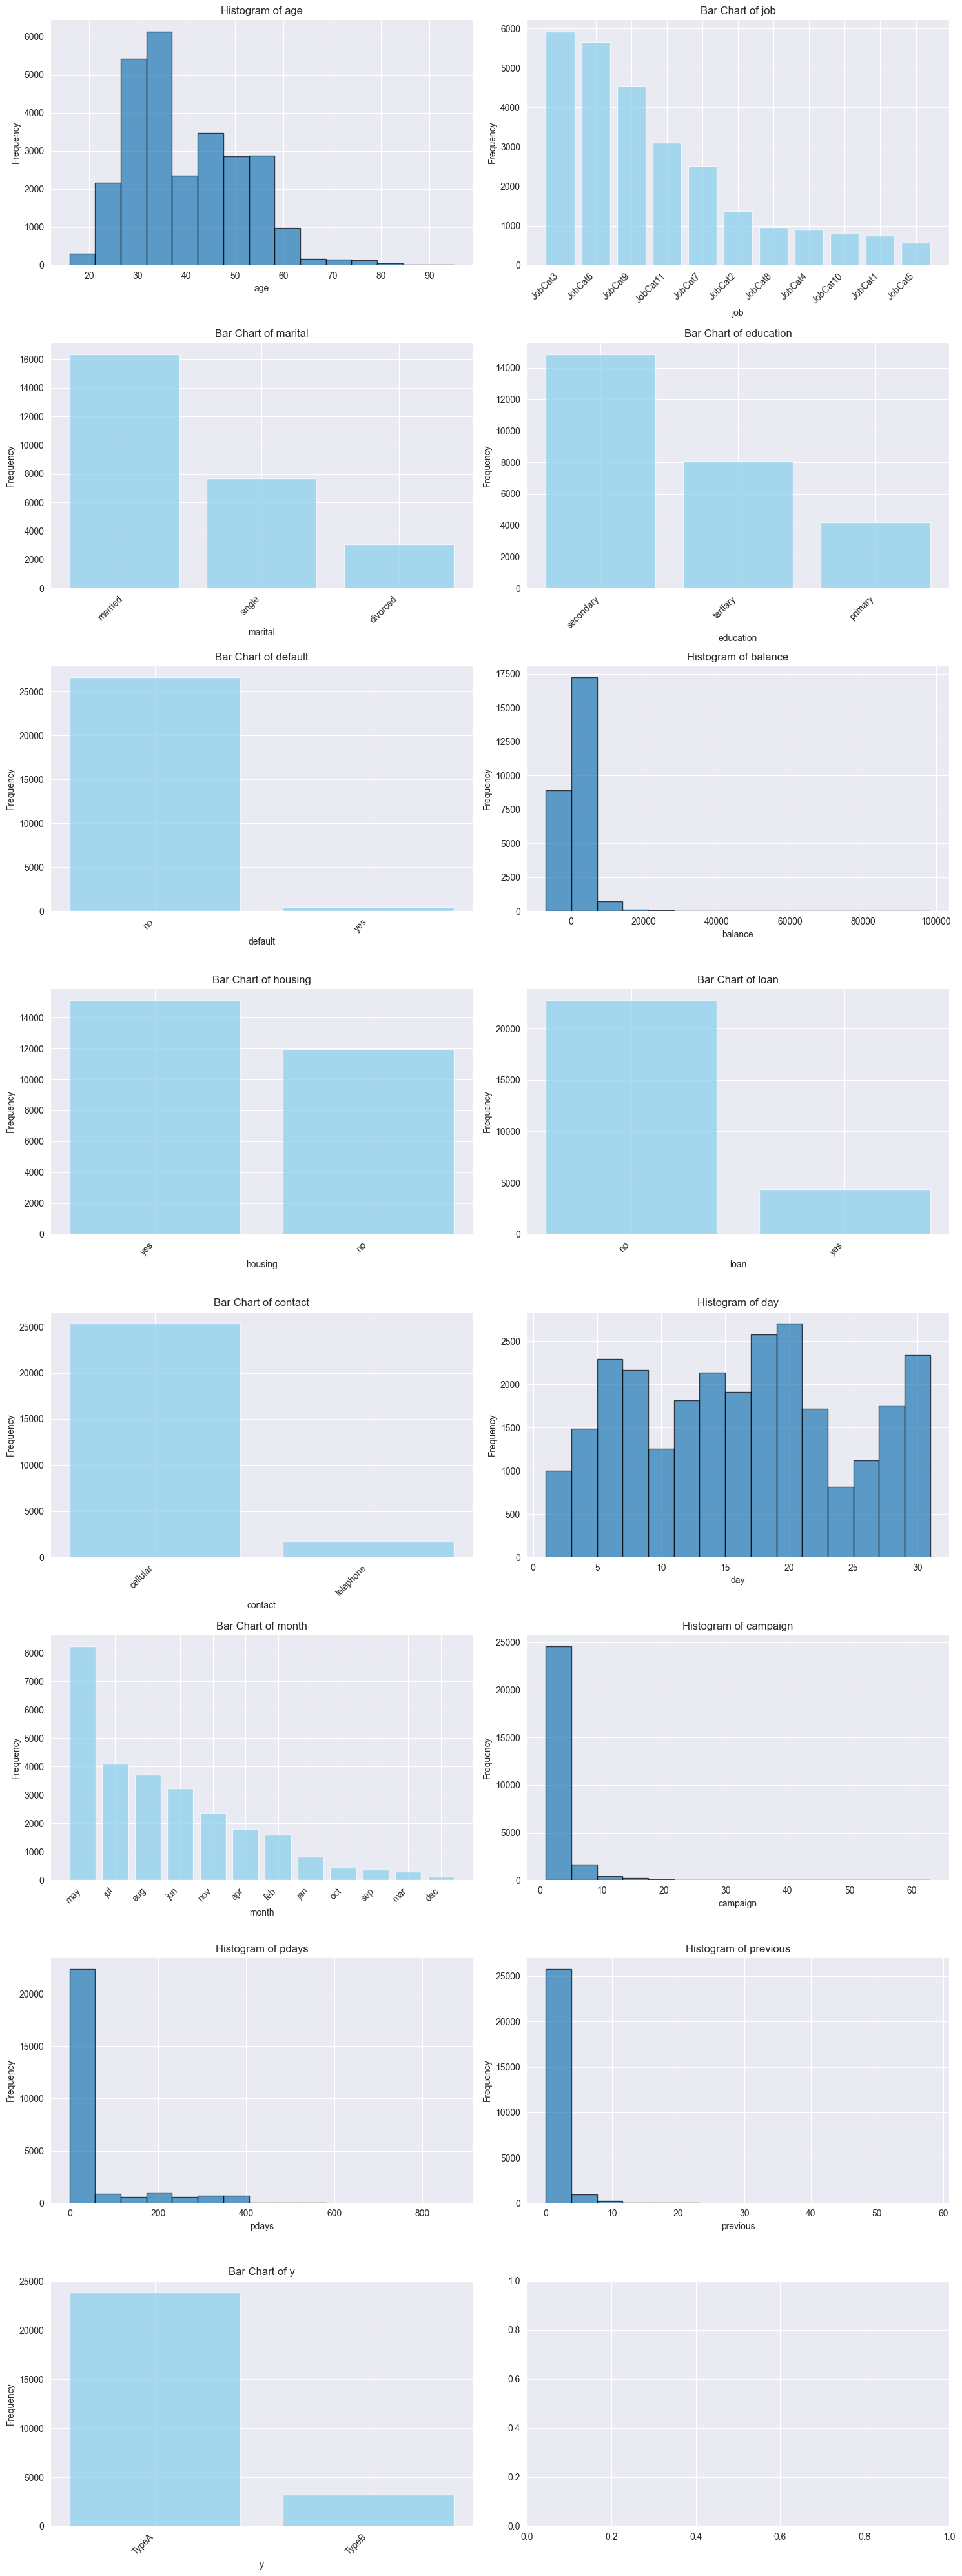

In [78]:
plot_data_distributions(dataset)

## Multiple interpolation methods
- time
- polynomial
- spline

**All the methods following the interpolation of the data have been done on all three types**
**The best performing data proved to be the polynomial one and as such that's the one I'm showing in the notebook**

## Time series analysis

## Linear correlations

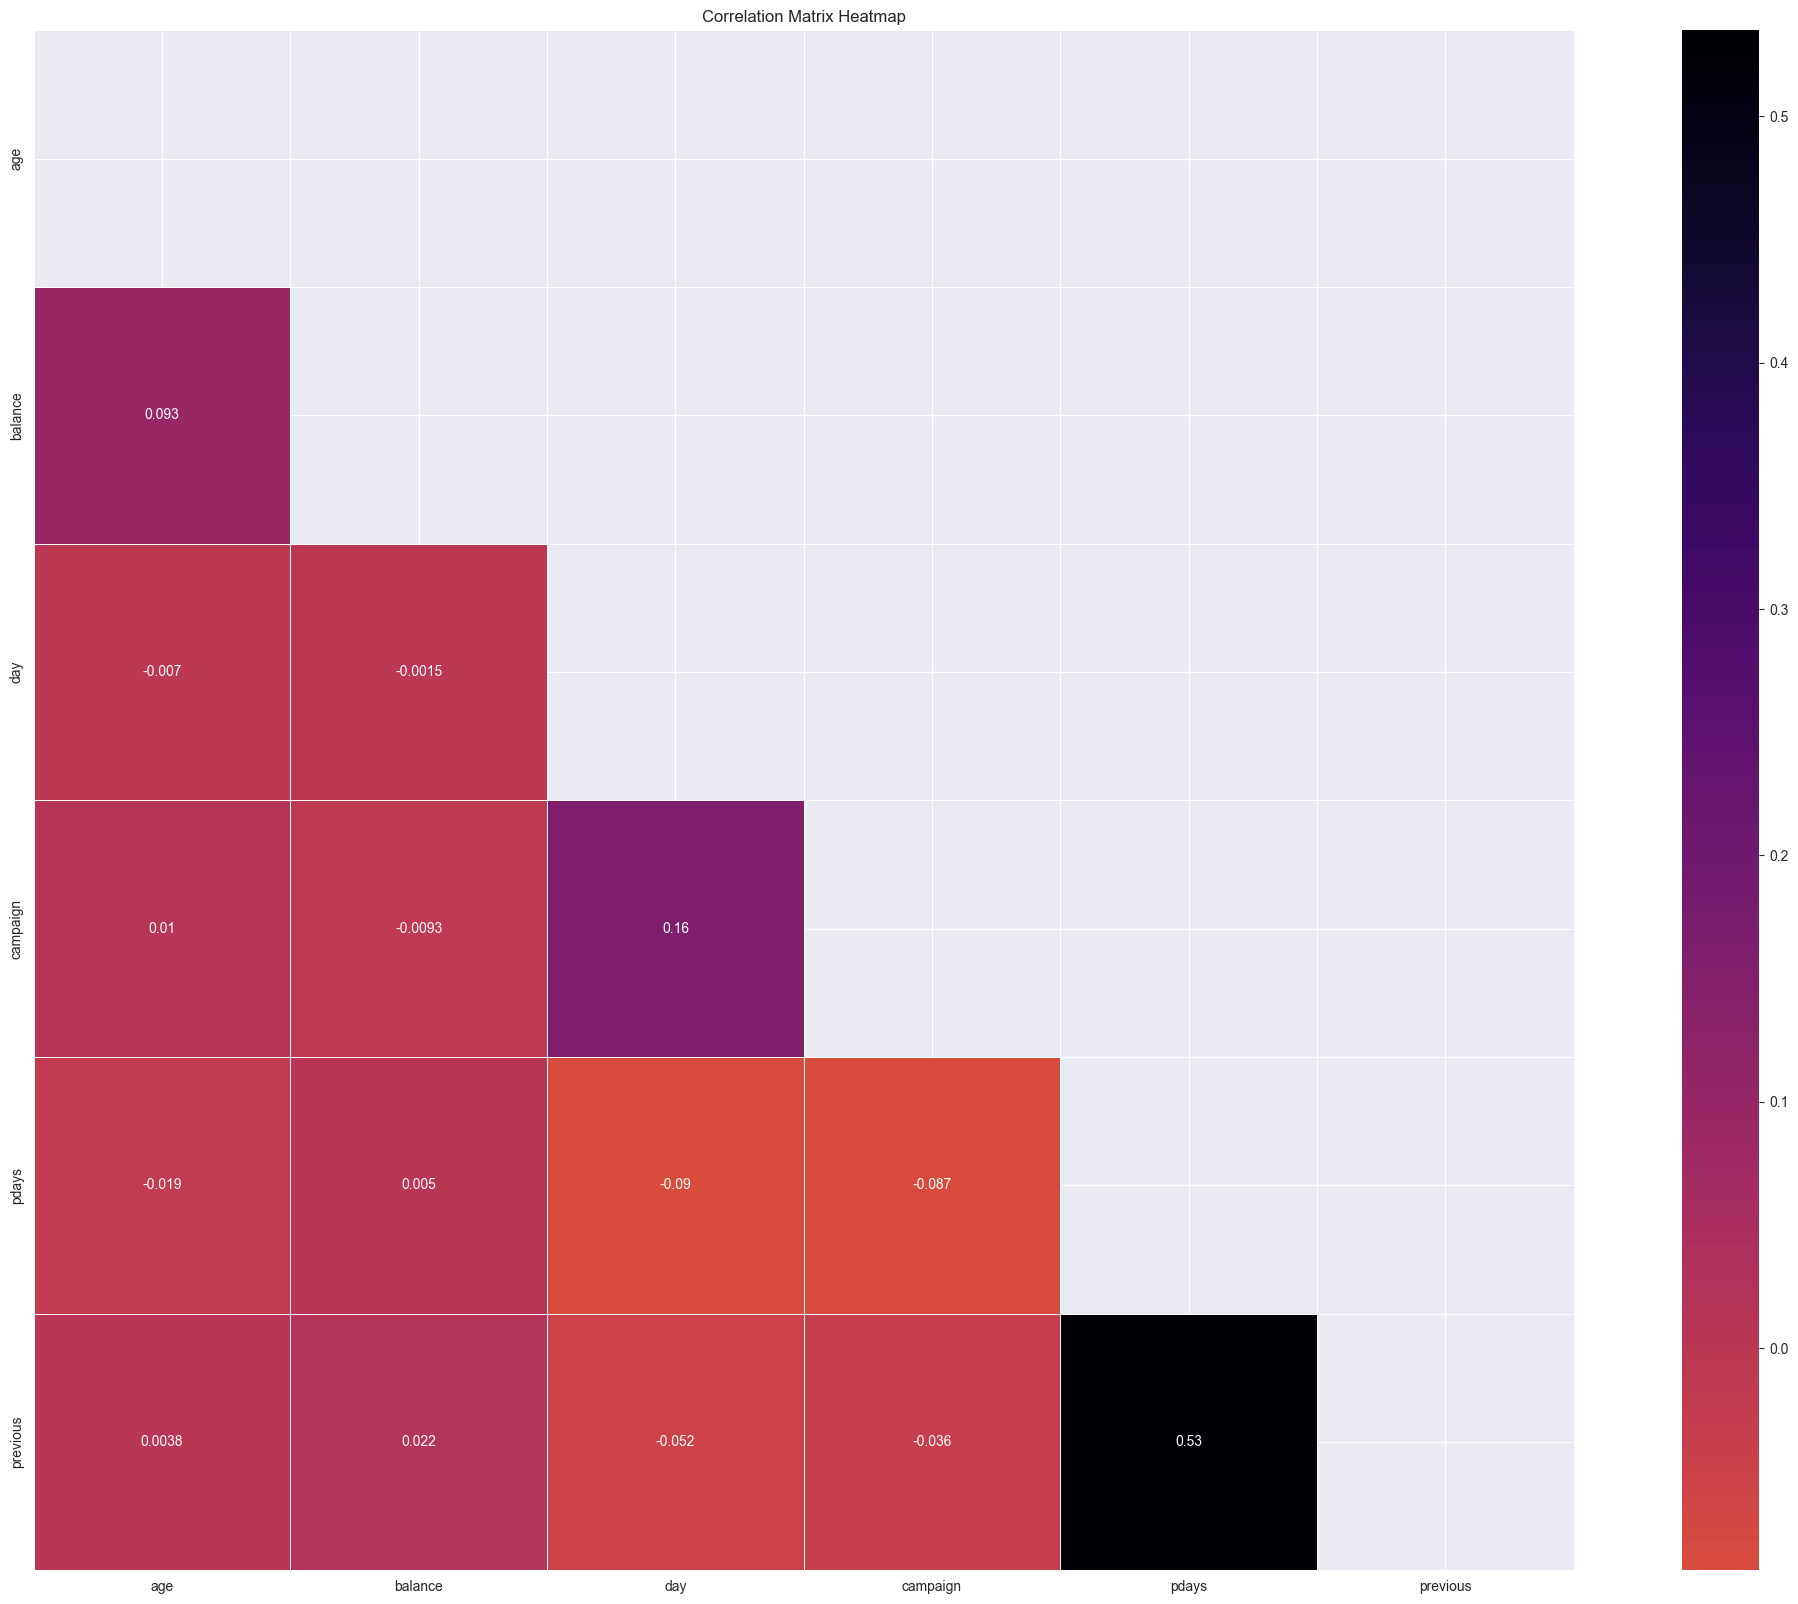

In [81]:

def calculate_correlations(dataframe):
    """
    Calculate the pairwise linear correlations between all numeric variables in a DataFrame.

    Args:
    dataframe: A pandas DataFrame.

    Returns:
    A pandas DataFrame representing the correlation matrix.
    """
    # Select only numeric columns
    numeric_df = dataframe.select_dtypes(include=[np.number])

    # Calculate the correlation matrix
    correlation_matrix = numeric_df.corr()

    return correlation_matrix


corr = calculate_correlations(dataset)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(28, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='inferno_r', center=0,
            square=True, linewidths=.5, annot=True)

plt.title('Correlation Matrix Heatmap')
plt.show()



## Target correlation
For linear correlation, Pearson's correlation coefficient is appropriate, but for non-linear relationships, we consider Spearman's rank correlation or Kendall's Tau. These methods can capture monotonic relationships, which are not necessarily linear.

## Choice of Model


Predicting the concentration of sludge over the next 4 hours is a time series forecasting problem. The choice of model depends on several factors, including the nature of the dataset, the patterns present in it (such as seasonality or trends), and the computational resources at our disposal.

ARIMA (Autoregressive Integrated Moving Average): This is a classic model for time series forecasting that is suitable for univariate datasets with a trend but no significant seasonality.

SARIMA (Seasonal ARIMA): An extension of ARIMA, this model is effective if our data exhibits strong seasonality.

Prophet: Developed by Facebook, Prophet is great for datasets with strong seasonal patterns and several seasons of historical data. It can handle outliers, missing data, and trend changes well.

LSTM (Long Short-Term Memory) Networks: If the dataset is large and we have the computational resources, LSTM, a type of recurrent neural network, can be very effective, especially if the relationships in our data are complex and non-linear.

XGBoost or Random Forest Regression: These ensemble learning methods can be used for time series forecasting by framing the problem as a regression. They might be particularly useful if we have several explanatory variables (features) in addition to the time component.

In this project, we will train the following models:
- Liner Regression : A simple linear regression model to establish a baseline.
- Random Forest: A tree-based ensemble learning method that can capture non-linear relationships.
- XGBoost: A gradient boosting ensemble learning method that can capture non-linear relationships
- ARIMA: A classic time series forecasting model that can capture trends in univariate data. (tried and failed miserably)
- univariate LSTM: A recurrent neural network that can capture complex non-linear relationships in univariate time series data.
- multivariate LSTM: A recurrent neural network that can capture complex non-linear relationships in multivariate time series data.


## Train-test Split

## Function: `prepare_dataframe_for_model`

### Purpose
Prepares a DataFrame for model training by splitting it into features and target variable.

### Parameters
- `dataframe`: A pandas DataFrame containing time series data.

### Returns
- A tuple `(X, y)`, where `X` is a DataFrame of features and `y` is a Series of the target variable.

### Functionality
- Extracts time-related features (`hour`, `minute`, `day`) from the DataFrame's index.
- Drops rows with missing values.
- Separates the DataFrame into features (`X`) and target variable (`y`).

### Data Splitting
- Splits `X` and `y` into training (80%), validation (10%), and testing (10%) sets.
- Adjusts validation set size to account for any division remainder.


In [170]:
X, y, pipeline, label_encoder = prepare_data(dataset)


## Model Training

In [169]:
unique, counts = np.unique(y, return_counts=True)
value_counts = dict(zip(unique, counts))

print(value_counts)


{np.int64(0): np.int64(23876), np.int64(1): np.int64(3218)}


In [168]:
import functions
# Do stuff...

# (Later after editing functions.py)
import importlib
importlib.reload(functions)
from functions import plot_data_distributions, prepare_data,train_test_cv_models,compare_models

In [ ]:
results= train_test_cv_models(X, y)

[I 2025-04-26 14:36:59,648] A new study created in memory with name: no-name-92b453da-9808-47c2-8126-47760ee0f001


Tuning and training knn...


[I 2025-04-26 14:37:03,027] Trial 0 finished with value: 0.9058703636775011 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9058703636775011.
[I 2025-04-26 14:37:05,987] Trial 1 finished with value: 0.9089720561034884 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9089720561034884.
[I 2025-04-26 14:37:09,159] Trial 2 finished with value: 0.8932072856682062 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9089720561034884.
[I 2025-04-26 14:37:09,802] Trial 3 finished with value: 0.8710046652232757 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.9089720561034884.
[I 2025-04-26 14:37:13,290] Trial 4 finished with value: 0.9003604347483005 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9089720561034884.
[I 2025-04-26 14:37:15,496] Trial 5 finish

In [163]:
results

{'knn': {'accuracy': 0.805868241372947,
  'precision': 0.2777777777777778,
  'recall': 0.39596273291925466,
  'f1': 0.3265044814340589,
  'roc_auc': np.float64(0.6778797437481707),
  'model': KNeighborsClassifier(n_neighbors=4, p=1, weights='distance'),
  'best_params': {'n_neighbors': 4, 'weights': 'distance', 'p': 1}},
 'decision_tree': {'accuracy': 0.824690902380513,
  'precision': 0.27890173410404623,
  'recall': 0.2996894409937888,
  'f1': 0.28892215568862273,
  'roc_auc': np.float64(0.6364300347956164),
  'model': DecisionTreeClassifier(class_weight='balanced', max_depth=30,
                         min_samples_split=9, random_state=42),
  'best_params': {'max_depth': 30,
   'min_samples_split': 9,
   'min_samples_leaf': 1,
   'max_features': None}},
 'random_forest': {'accuracy': 0.8752537368518177,
  'precision': 0.4652173913043478,
  'recall': 0.33229813664596275,
  'f1': 0.38768115942028986,
  'roc_auc': np.float64(0.7667724626841403),
  'model': RandomForestClassifier(bootst

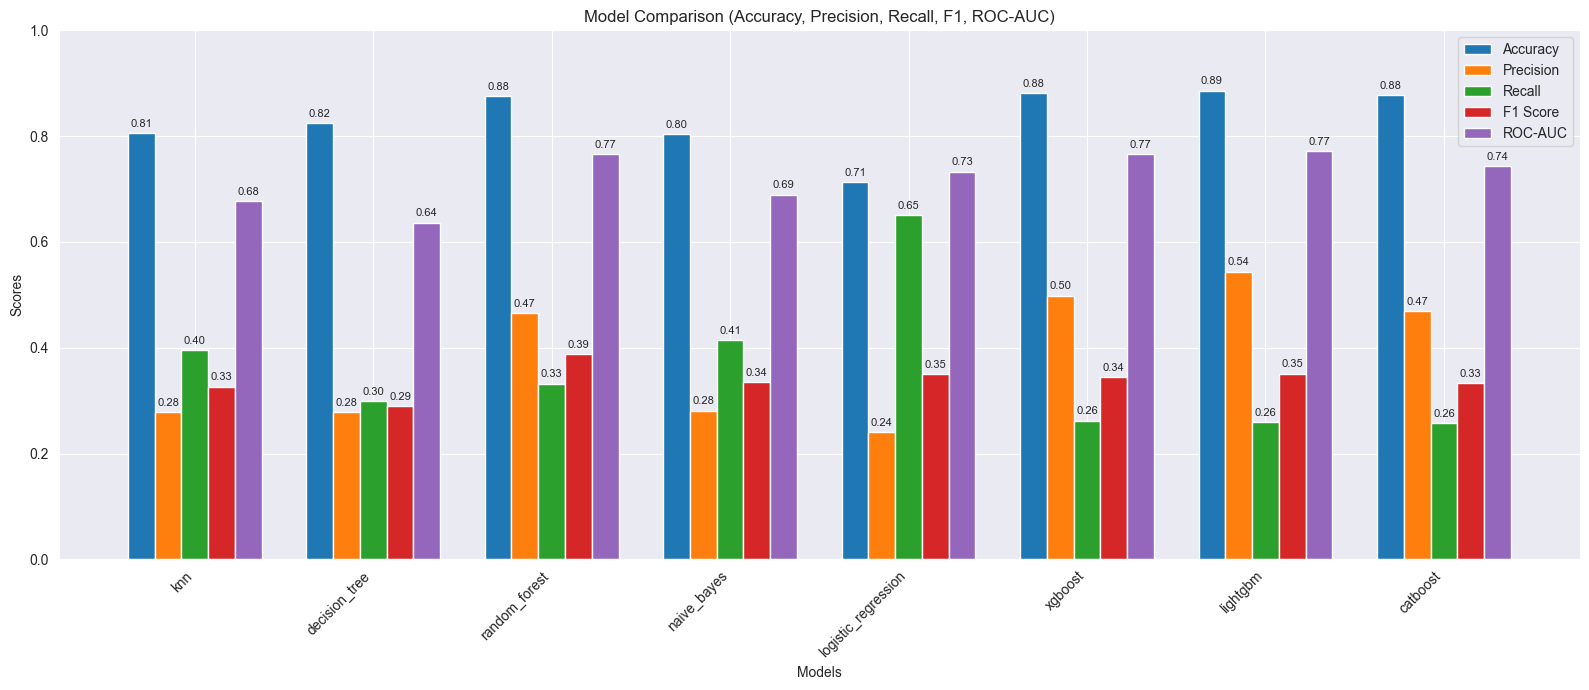

In [162]:
compare_models(results)

In [20]:
X_full = pd.concat([X_train, X_test])
y_full= pd.concat([y_train, y_test])
polynomial_results = train_test_cv_models(X_full, y_full)
polynomial_results

Training and testing linear_regression...
Training and testing random_forest...
Training and testing xgboost...
Completed linear_regression.
Completed random_forest.
Completed xgboost.


{'linear_regression': {'model': LinearRegression(),
  'mae': 23.564361374284672,
  'mse': 1015.4650785622648},
 'random_forest': {'model': RandomForestRegressor(max_depth=10, min_samples_leaf=10, n_jobs=-1,
                        random_state=42),
  'mae': 4.61569910641374,
  'mse': 89.87363910781175},
 'xgboost': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.1, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=10, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estim

## LSTM

## Function: `train_lstm_model`

### Purpose
Train an LSTM model and evaluate it on a train-test split.

### Parameters
- `X_train`: Training features.
- `y_train`: Training target.
- `X_test`: Testing features.
- `y_test`: Testing target.
- `epochs`: Number of epochs to train the model.
- `batch_size`: Batch size for training.

### Returns
- The trained LSTM model and the mean squared error on the test set.

### Functionality
- Initializes MinMax scalers for feature and target scaling.
- Converts data to NumPy arrays and scales the training and testing data.
- Reshapes input for LSTM model.
- Defines an LSTM model architecture with specified layers.
- Compiles the model with 'adam' optimizer and 'mean_squared_error' loss.
- Trains the model on the training data.
- Predicts on the test data and computes MSE and MAE.
- Returns the model, MSE, MAE, feature scaler, and target scaler.



## Function: `train_lstm_multivariate`

### Purpose
Train an LSTM model on multivariate time series data and evaluate it on a train-test split.

### Parameters
- `data`: A pandas DataFrame containing the time series data.
- `target_column`: The name of the target column in the DataFrame.
- `time_step`: The number of previous time steps to consider for predicting the next value.
- `epochs`: Number of epochs to train the model.
- `test_size`: Proportion of the dataset to include in the test split.
- `batch_size`: Batch size for training.

### Returns
- The trained LSTM model and the mean squared error on the test set.

### Functionality
- Normalizes the dataset using MinMaxScaler.
- Creates a dataset with specified time steps and target column.
- Splits the dataset into train and test sets.
- Reshapes input for LSTM model.
- Defines an LSTM model architecture with specified layers.
- Compiles the model with 'adam' optimizer and 'mean_squared_error' loss.
- Trains the model on the training data.
- Predicts on the test data, scales back to original values, and computes MSE and MAE.
- Returns the model, MSE, MAE, and the scaler used for normalization.


In [23]:
def validate_model_accuracy(models, X_val, y_val):
    """
    Validates the accuracy of multiple models on a given validation dataset.
    """
    validation_results = {}
    for model_name, model_info in models.items():
        model = model_info['model']
        # Predict on the validation set
        val_predictions = model.predict(X_val)
        # Calculate Mean Squared Error and Mean Absolute Error
        val_mse = mean_squared_error(y_val, val_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        validation_results[model_name] = {'val_mse': val_mse, 'val_mae': val_mae}
        print(f"Validation results for {model_name} - MSE: {val_mse}, MAE: {val_mae}")

    return validation_results
validation_results = validate_model_accuracy(polynomial_results, X_val, y_val)


Validation results for linear_regression - MSE: 2256.3161531606243, MAE: 42.77624116376433
Validation results for random_forest - MSE: 893.3453405765729, MAE: 22.09738894549453
Validation results for xgboost - MSE: 643.789754362379, MAE: 20.472498560666942


In [24]:
def validate_lstm_model_accuracy(model, scaler_X, scaler_y, X_val, y_val):
    """
    Validates the LSTM model accuracy on a given validation dataset.

    Args:
    model: Trained LSTM model.
    scaler_X: Scaler used for input features.
    scaler_y: Scaler used for target values.
    X_val: Validation features.
    y_val: Validation target.

    Returns:
    Mean Squared Error and Mean Absolute Error on the validation set.
    """

    # Scale the validation data
    X_val_scaled = scaler_X.transform(np.array(X_val))
    y_val_scaled = scaler_y.transform(np.array(y_val).reshape(-1, 1))

    # Reshape input for LSTM
    time_step = X_val_scaled.shape[1]
    X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], time_step, 1)

    # Predict on validation data
    val_predict = model.predict(X_val_reshaped)
    val_predict = scaler_y.inverse_transform(val_predict)

    # Calculate MSE and MAE
    val_mse = mean_squared_error(y_val, val_predict[:, 0])
    val_mae = mean_absolute_error(y_val, val_predict[:, 0])

    return val_mse, val_mae


In [25]:
# Assuming X_val and y_val are your validation features and targets
validation_mse, validation_mae = validate_lstm_model_accuracy(univariate_lstm_model, univariate_scaler_X, univariate_scaler_Y, X_val, y_val)
print(f"Validation Mean Squared Error: {validation_mse}")
print(f"Validation Mean Absolute Error: {validation_mae}")


156/156 [==============================] - 0s 2ms/step
Validation Mean Squared Error: 1427.9097063868073
Validation Mean Absolute Error: 31.60270779382037


In [26]:
def validate_lstm_multivariate_model_accuracy(model, scaler, validation_data, time_step, target_column_index):
    """
    Validates the LSTM model accuracy on a given multivariate validation dataset.

    Args:
    model: Trained LSTM model.
    scaler: Scaler used for the entire dataset.
    X_val: Multivariate validation features.
    y_val: Validation target.
    time_step: The number of previous time steps considered for prediction.
    target_column_index: The index of the target column in the scaled dataset.

    Returns:
    Mean Squared Error and Mean Absolute Error on the validation set.
    """

    # Reshape and scale validation data
    X_val_scaled, y_val_scaled = create_dataset_multivariate(pd.DataFrame(scaler.transform(validation_data), columns=validation_data.columns),
                                                            target_column_index, time_step)

    # Predict on validation data
    val_predict = model.predict(X_val_scaled)
    val_predict_rescaled = scaler.inverse_transform(np.concatenate((val_predict, np.zeros((val_predict.shape[0], X_val_scaled.shape[2]-1))), axis=1))[:,0]
    y_val_rescaled = scaler.inverse_transform(np.concatenate((y_val_scaled.reshape(-1,1), np.zeros((y_val_scaled.shape[0], X_val_scaled.shape[2]-1))), axis=1))[:,0]

    # Calculate MSE and MAE
    val_mse = mean_squared_error(y_val_rescaled, val_predict_rescaled)
    val_mae = mean_absolute_error(y_val_rescaled, val_predict_rescaled)

    return val_mse, val_mae, val_predict_rescaled


# Assuming X_val and y_val are your validation features and target, and 'target_column_index' is the index of the target variable in the scaled dataset
# Combine X_val and y_val into a single DataFrame
validation_data = pd.concat([X_val, y_val], axis=1)
validation_mse, validation_mae, val_predict_rescaled = validate_lstm_multivariate_model_accuracy(multivariate_lstm_model, multivariate_scaler, validation_data, time_step=64, target_column_index=data.columns.get_loc('Target variable'))
print(f"Validation Mean Squared Error: {validation_mse}")
print(f"Validation Mean Absolute Error: {validation_mae}")



  1/154 [..............................] - ETA: 1s

/tmp/ipykernel_62392/74958134.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y.append(data.iloc[i + time_step][target_column])


154/154 [==============================] - 0s 2ms/step
Validation Mean Squared Error: 0.011308498050475407
Validation Mean Absolute Error: 0.07454585392089766


## Function: `predict_future_intervals`

### Purpose
Predict future intervals using a trained multivariate LSTM model.

### Parameters
- `model`: The trained LSTM model.
- `scaler`: Scaler used for the dataset.
- `last_data`: The most recent data point(s) for making predictions.
- `time_step`: The number of time steps the model was trained on.
- `n_intervals`: Number of future intervals to predict (default 48 for 4 hours at 5-minute intervals).
- `n_features`: Number of features in the dataset (optional).

### Returns
- Predictions for the specified number of future intervals.

### Functionality
- Converts the DataFrame to a NumPy array if necessary.
- Prepares the initial input sequence using the most recent data.
- Iteratively makes predictions for the specified number of future intervals.
- Updates the input sequence for each prediction.
- Rescales predictions back to the original scale using the provided scaler.
- Returns the predictions.

In [27]:
def predict_future_intervals(model, scaler, last_data, time_step, n_intervals=48, n_features=None):
    """
    Predict future intervals using a trained multivariate LSTM model.

    Args:
    model: The trained LSTM model.
    scaler: Scaler used for the dataset.
    last_data: The most recent data point(s) for making predictions.
    time_step: The number of time steps the model was trained on.
    n_intervals: Number of future intervals to predict (default 48 for 4 hours at 5-minute intervals).
    n_features: Number of features in the dataset.

    Returns:
    Predictions for the specified number of future intervals.
    """

    # Convert DataFrame to NumPy array and ensure the correct shape
    if isinstance(last_data, pd.DataFrame):
        last_data = last_data.values

    if n_features is None:
        n_features = last_data.shape[1]

    # Prepare the initial input sequence
    input_seq = last_data[-time_step:].reshape(1, time_step, n_features)

    predictions = []
    for _ in range(n_intervals):
        # Make a prediction
        pred = model.predict(input_seq)

        # Append the prediction (only the target variable part)
        predictions.append(pred[0, 0])

        # Update the input sequence for the next prediction
        # Reshape pred to match the feature dimension
        pred_reshaped = np.zeros((1, n_features))
        pred_reshaped[0, 0] = pred[0, 0]  # assuming the target variable is the first feature
        next_input_seq = np.append(input_seq[0, 1:, :], pred_reshaped, axis=0).reshape(1, time_step, n_features)
        input_seq = next_input_seq

    # Rescale predictions back to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], n_features-1))), axis=1))[:,0]

    return predictions_rescaled



# last_data should be the most recent 'time_step' records in the correct format
predictions = predict_future_intervals(multivariate_lstm_model, multivariate_scaler, validation_data.iloc[-128:], time_step=64, n_intervals=48, n_features=data.shape[1])


1/1 [==============================] - 0s 14ms/step


In [28]:
start_date = validation_data.index[-1] 
end_date = start_date + timedelta(minutes=5 * 200)  # 48 intervals of 5 minutes each
# Define the columns and their data types based on the information you provided
columns_and_dtypes = {
    'O2 percentage in tank 1': float,
    'Liquid to reduce the pH in tank 1': float,
    'Filtered sludge going back to tank 1': float,
    'Outside air tank 1': float,
    'Height in tank 1': float,
    'Flowrate to pH measurement in tank 1': float,
    'pH of liquid in tank 1': float,
    'Flowrate to O2 measurement in tank 1': float,
    'O2 dissolved in tank 1': float,
    'Temperature of liquid in tank 1': float,
    'Consentration of sludge': float,
    'Conductivity': float,
    'O2 percentage in tank 2': float,
    'Liquid to reduce the pH in tank 2': float,
    'Filtered sludge going back to tank 2': float,
    'Outside air tank 2': float,
    'Height in tank 2': float,
    'Flowrate to pH measurement in tank 2': float,
    'pH of liquid in tank 2': float,
    'Flowrate to O2 measurement in tank 2': float,
    'O2 dissolved in tank 2': float,
    'Temperature of liquid in tank 2': float,
    'Temperature input a': float,
    'Amount of sludge in water input a': float,
    'Conductivity input a': float,
    'toc input a': float,
    'pH input a': float,
    'Temperature input b': float,
    'Flowrate input b': float,
    'Amount of sludge in water input b': float,
    'Conductivity input b': float,
    'pH input b': float,
    'Target variable': float
}

# Create a time series index with 5-minute intervals into the future
original_df = validation_data.copy()
time_index = pd.date_range(start=start_date, end=end_date, freq='5T')

# Create a new DataFrame with the defined columns and data types
new_df = pd.DataFrame(index=time_index, columns=columns_and_dtypes.keys()).astype(columns_and_dtypes)

# Iterate through the time series index and calculate the rolling average for each column
window_size = 128  # You can adjust the window size as needed
for timestamp in time_index:
    start_time = timestamp - timedelta(minutes=5 * window_size)
    end_time = timestamp
    window_data = original_df[(original_df.index >= start_time) & (original_df.index <= end_time)]
    rolling_avg = window_data.mean()
    new_df.loc[timestamp] = rolling_avg

new_x, new_y = prepare_dataframe_for_model(new_df)
new_data=pd.concat([new_x,new_y],axis=1)

In [29]:
moving_average_predictions = predict_future_intervals(multivariate_lstm_model, multivariate_scaler, new_data, time_step=64, n_intervals=48, n_features=new_data.shape[1])

1/1 [==============================] - 0s 14ms/step


In [30]:


def plot_predictions_with_actual_data(actual_data, predictions, interval_minutes=5, last_n_entries=256):
    """
    Plot the last n entries of the actual data and the predicted values against their corresponding timestamps.

    Args:
    actual_data: A pandas DataFrame with timestamps as index and target values in a column.
    predictions: A list or array of predicted values.
    interval_minutes: The interval between predictions in minutes.
    last_n_entries: The number of last entries from actual data to plot.
    """

    # Extract the last n entries from the actual data
    last_actual_data = actual_data.iloc[-last_n_entries:]

    # Determine the start timestamp for predictions
    # It's the next timestamp after the last actual data timestamp
    start_timestamp = last_actual_data.index[-1] + timedelta(minutes=interval_minutes)

    # Create a date range for predictions
    timestamps = pd.date_range(start=start_timestamp, periods=len(predictions), freq=f'{interval_minutes}T')

    # Plotting
    plt.figure(figsize=(15, 6))

    # Plot actual data
    plt.plot(last_actual_data.index, last_actual_data.iloc[:, 0], marker='o', label='Actual Data')

    # Plot predictions
    plt.plot(timestamps, predictions, marker='o', label='Predictions')

    plt.title('Actual Data and Predictions Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.show()

# Example usage


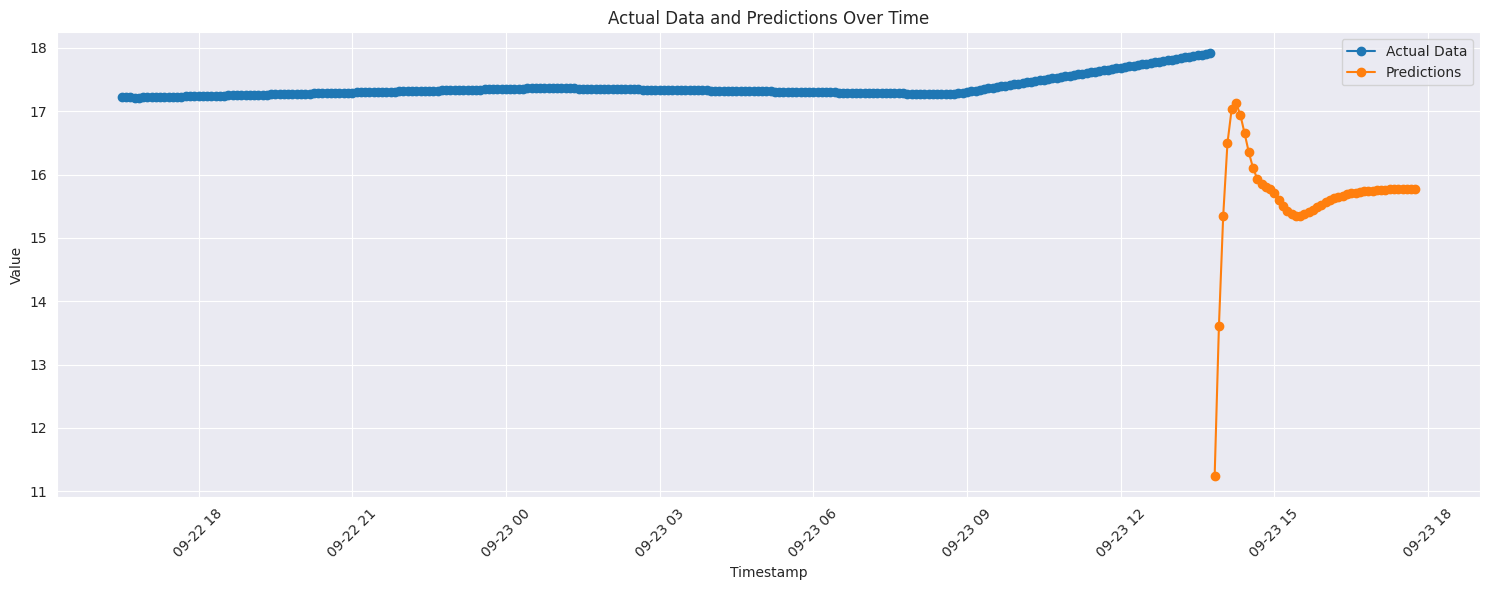

In [31]:
plot_predictions_with_actual_data(validation_data, predictions, interval_minutes=5, last_n_entries=256)

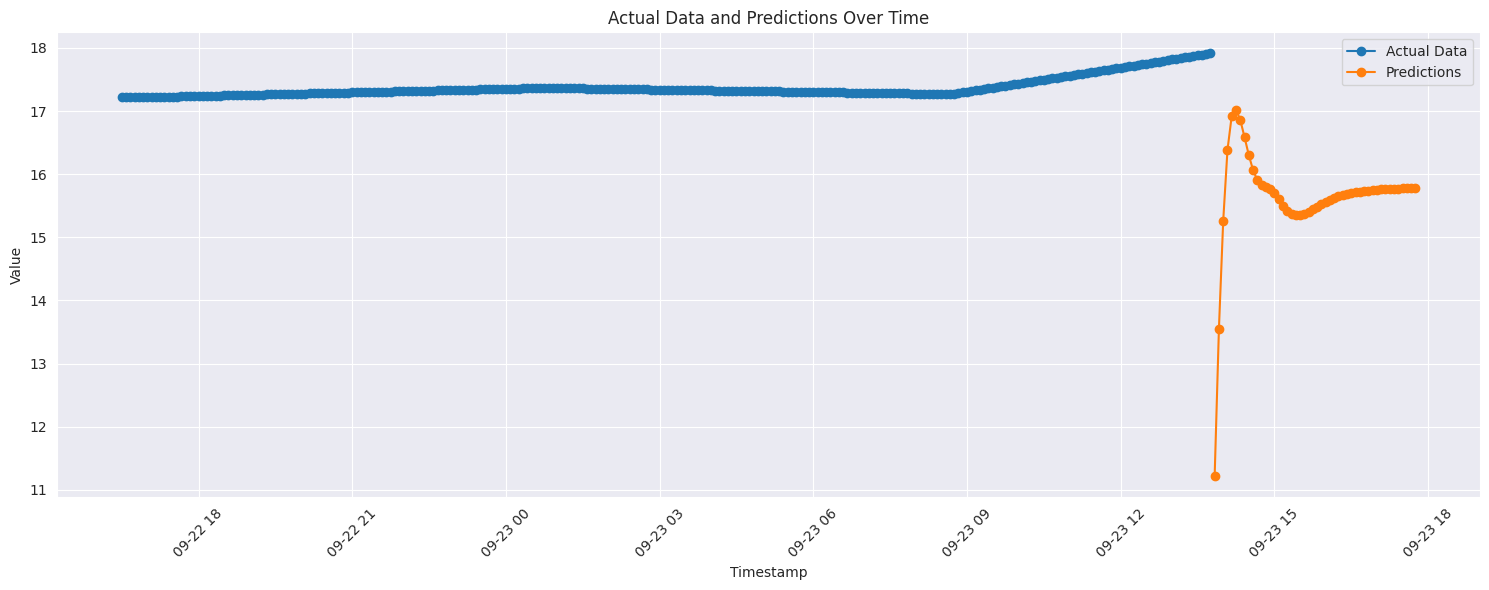

In [32]:
plot_predictions_with_actual_data(pd.concat([X_val,y_val],axis=1), moving_average_predictions, last_n_entries=256)


## Explaining the Results

### Testing Results:

Three machine learning models were evaluated on a testing dataset, and the following performance metrics were reported:

- **Linear Regression**:
  - Mean Absolute Error (MAE): 23.56
  - Mean Squared Error (MSE): 1015.47

- **Random Forest**:
  - MAE: 4.62
  - MSE: 89.87

- **XGBoost**:
  - MAE: 1.50
  - MSE: 18.63

### Validation Results:

The same three models were evaluated on a separate validation dataset to assess their generalization capability. The validation results are as follows:

- **Linear Regression**:
  - MAE: 42.78
  - MSE: 2256.32

- **Random Forest**:
  - MAE: 22.10
  - MSE: 893.35

- **XGBoost**:
  - MAE: 20.47
  - MSE: 643.79

### Univariate LSTM and Multivariate LSTM:

Two additional models or techniques were evaluated:

- **Univariate LSTM**:
  - Validation MSE: 1427.91
  - Validation MAE: 31.60

- **Multivariate LSTM**:
  - Validation MSE: 0.0113
  - Validation MAE: 0.0745

In summary, the Random Forest and XGBoost models outperformed the Linear Regression model in terms of both MAE and MSE on both testing and validation datasets. The text also includes results from two types of LSTM models, which exhibited varying levels of performance compared to the traditional machine learning models.
